In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import os
import random
from typing import List
import matplotlib.pyplot as plt
from google.colab import drive
!pip install gcsfs


/tmp/ipython-input-69809291.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=global_label_counts.index, y=global_label_counts.values, palette='viridis')


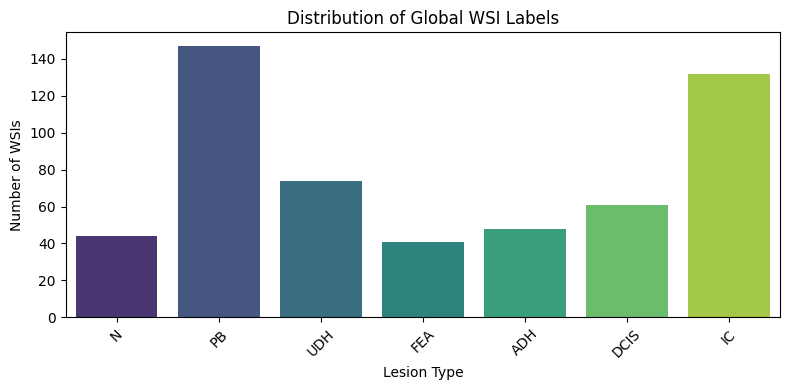

/tmp/ipython-input-69809291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_series.index, y=region_series.values, palette='mako')


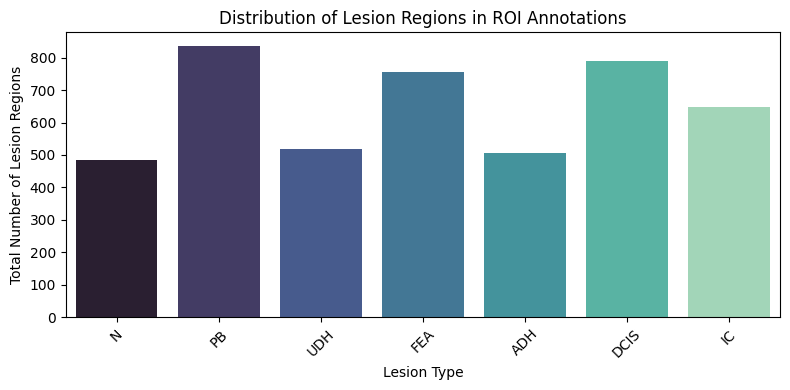

In [3]:
# Reload the data since the session has likely reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load both sheets from the Excel file
xls = pd.ExcelFile("BRACS_BRACS.xlsx")
df_info = pd.read_excel(xls, 'WSI_Information')
df_roi = pd.read_excel(xls, 'WSI_with_RoI_Distribution')

# Set the lesion order
lesions = ['N', 'PB', 'UDH', 'FEA', 'ADH', 'DCIS', 'IC']

# Plot 1: Distribution of global labels (in defined lesion order)
global_label_counts = df_info['WSI label'].value_counts()
global_label_counts = global_label_counts.reindex(lesions).fillna(0)

plt.figure(figsize=(8, 4))
sns.barplot(x=global_label_counts.index, y=global_label_counts.values, palette='viridis')
plt.title("Distribution of Global WSI Labels")
plt.xlabel("Lesion Type")
plt.ylabel("Number of WSIs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of lesion region counts (in defined lesion order)
lesion_region_counts = {lesion: 0 for lesion in lesions}
for _, row in df_roi.iterrows():
    for lesion in lesions:
        val = row.get(lesion)
        if pd.notna(val) and val != '-' and int(val) > 0:
            lesion_region_counts[lesion] += int(val)

region_series = pd.Series(lesion_region_counts).reindex(lesions)

plt.figure(figsize=(8, 4))
sns.barplot(x=region_series.index, y=region_series.values, palette='mako')
plt.title("Distribution of Lesion Regions in ROI Annotations")
plt.xlabel("Lesion Type")
plt.ylabel("Total Number of Lesion Regions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# Step 1: Install the required library
!pip install -q gcsfs

# Step 2: Authenticate to access Google Cloud Storage
from google.colab import auth
auth.authenticate_user()

# Step 3: Use gcsfs to interact with your bucket
import gcsfs

# Replace with your actual project ID if needed
fs = gcsfs.GCSFileSystem()

# Path to the training embeddings folder
embedding_base_path = 'bracs-dataset-bucket/patch-embeddings/train'

# List everything under that path
all_entries = fs.ls(embedding_base_path)

# Keep only the .pt files
pt_files = [p for p in all_entries if p.endswith('.pt')]

print(f"Found {len(pt_files)} embedding files:\n")


Found 94 embedding files:



In [5]:
import os
splits = ['train']
all_slide_paths = []

for split in splits:
    split_path = f"bracs-dataset-bucket/patch-embeddings/{split}"
    slide_files = fs.find(split_path)  # recursively lists files
    for f in slide_files:
        if f.endswith('_embeddings.pt'):
            all_slide_paths.append((split, f))

print(f"✅ Found {len(all_slide_paths)} total WSI embeddings {split}.")

import torch
import io

wsi_patch_counts = []

for split, path in all_slide_paths:
    try:
        with fs.open(path, 'rb') as f:
            data = torch.load(io.BytesIO(f.read()))
        num_patches = data.shape[0]
        stem     = os.path.splitext(os.path.basename(path))[0]
        wsi_id   = stem.rsplit("_", 1)[0]

        wsi_patch_counts.append((wsi_id, num_patches))
    except Exception as e:
        print(f"❌ Error loading {path}: {e}")

✅ Found 94 total WSI embeddings train.


In [16]:
print(all_slide_paths)

[('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003658_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003659_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003669_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003671_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003672_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003675_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003686_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003693_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003700_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003706_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/train/BRACS_1003710_embeddings.pt'), ('train', 'bracs-dataset-bucket/patch-embeddings/trai

In [7]:
# Create DataFrame
df = pd.DataFrame(wsi_patch_counts, columns=['WSI', 'Num_Patches'])

# Sort by patch count
df_sorted = df.sort_values(by='Num_Patches', ascending=True)

# Print all
print("🔢 WSI Patch Counts (sorted by size):\n")
for i, row in df_sorted.iterrows():
    print(f"{row['WSI']}: {row['Num_Patches']} patches")

🔢 WSI Patch Counts (sorted by size):

BRACS_1003675: 9 patches
BRACS_1003718: 9 patches
BRACS_1003714: 9 patches
BRACS_1003713: 9 patches
BRACS_1616: 9 patches
BRACS_1403: 9 patches
BRACS_1401: 9 patches
BRACS_1379: 9 patches
BRACS_1378: 10 patches
BRACS_1003669: 12 patches
BRACS_1645: 19 patches
BRACS_1513: 41 patches
BRACS_1003715: 43 patches
BRACS_1499: 57 patches
BRACS_3292: 59 patches
BRACS_1003734: 61 patches
BRACS_1641: 73 patches
BRACS_3282: 122 patches
BRACS_3277: 123 patches
BRACS_1003706: 140 patches
BRACS_1003725: 146 patches
BRACS_1003716: 190 patches
BRACS_1882: 205 patches
BRACS_1248: 206 patches
BRACS_1249: 216 patches
BRACS_1622: 244 patches
BRACS_1658: 252 patches
BRACS_1911: 255 patches
BRACS_1774: 262 patches
BRACS_1510: 290 patches
BRACS_3318: 310 patches
BRACS_1932: 315 patches
BRACS_1778: 318 patches
BRACS_1003671: 322 patches
BRACS_1788: 333 patches
BRACS_1507: 341 patches
BRACS_1916: 344 patches
BRACS_1003659: 360 patches
BRACS_1267: 362 patches
BRACS_1912: 363

Final Severity-Aware Similarity Matrix (Shier):
          N     PB    UDH    FEA    ADH   DCIS     IC
N     0.500  0.016  0.014  0.010  0.005  0.002  0.001
PB    0.016  0.510  0.069  0.051  0.024  0.011  0.003
UDH   0.014  0.069  0.540  0.119  0.056  0.025  0.007
FEA   0.010  0.051  0.119  0.590  0.114  0.050  0.013
ADH   0.005  0.024  0.056  0.114  0.750  0.174  0.046
DCIS  0.002  0.011  0.025  0.050  0.174  0.990  0.149
IC    0.001  0.003  0.007  0.013  0.046  0.149  1.500


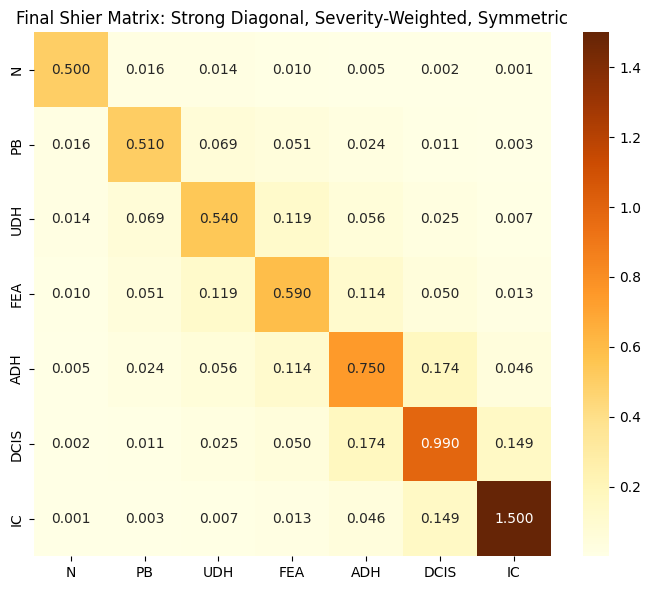

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Label severity: from least to most severe
labels = ['N', 'PB', 'UDH', 'FEA', 'ADH', 'DCIS', 'IC']
severity = torch.tensor([0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
n = len(severity)

# Parameters
epsilon = 0.5   # ensures N–N > anything–N
gamma = 2.0      # grows self-similarity faster with severity
delta = 0.8      # scale for off-diagonal similarities
alpha = 5.0      # decay rate for off-diagonal distances

# Initialize similarity matrix
M_shier = torch.zeros((n, n))

for i in range(n):
    for j in range(n):
        s_i = severity[i]
        s_j = severity[j]
        if i == j:
            M_shier[i, j] = epsilon + s_i**gamma
        else:
            M_shier[i, j] = delta * torch.sqrt(s_i * s_j) * torch.exp(-alpha * torch.abs(s_i - s_j))

# Pretty print matrix
df = pd.DataFrame(M_shier.numpy(), index=labels, columns=labels)
print("Final Severity-Aware Similarity Matrix (Shier):")
print(df.round(3))

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(df, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("Final Shier Matrix: Strong Diagonal, Severity-Weighted, Symmetric")
plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def masked_mean(feats: torch.Tensor, mask: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    feats: [B, P, H]
    mask:  [B, P]   (1 for valid patches, 0 for padding)
    returns: [B, H] mean over P, ignoring masked-out entries
    """
    # ensure float mask
    mask = mask.to(feats.dtype).unsqueeze(-1)        # [B, P, 1]
    summed = (feats * mask).sum(dim=1)               # [B, H]
    counts = mask.sum(dim=1).clamp(min=eps)          # [B, 1]
    return summed / counts

class SeparableLITEScorer(nn.Module):
    def __init__(self, max_query_patches=256, max_doc_patches=256, hidden_dim=128):
        super().__init__()
        self.max_query_patches = max_query_patches
        self.max_doc_patches = max_doc_patches

        # Row-wise MLP over doc dimension
        self.row_mlp = nn.Sequential(
            nn.LayerNorm(max_doc_patches),
            nn.Linear(max_doc_patches, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_doc_patches)
        )

        # Column-wise MLP over query dimension
        self.col_mlp = nn.Sequential(
            nn.LayerNorm(max_query_patches),
            nn.Linear(max_query_patches, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_query_patches)
        )

        # Final projection to scalar
        self.final_proj = nn.Linear(max_query_patches * max_doc_patches, 1)

    def forward(self, S: torch.Tensor, q_mask: torch.Tensor, d_mask: torch.Tensor):
        # S: [B, m, n]
        B, m, n = S.shape

        # 1) Row-wise MLP
        # reshape to [B*m, n] so each of the B*m rows is one input
        S_rows = S.reshape(B * m, n)                          # [B*m, n]
        out_rows = self.row_mlp(S_rows)                       # [B*m, hidden]
        out_rows = out_rows.view(B, m, -1)                    # [B, m, hidden]

        # 2) Column-wise MLP
        # first transpose to get [B, n, m], then flatten to [B*n, m]
        S_cols = S.transpose(1, 2).reshape(B * n, m)          # [B*n, m]
        out_cols = self.col_mlp(S_cols)                       # [B*n, hidden]
        out_cols = out_cols.view(B, n, -1)                    # [B, n, hidden]

        # 3) Masked pooling (example: mean over valid patches)
        # apply q_mask and d_mask to each feature map, then pool over patch dim
        # you’ll get two vectors of shape [B, hidden]
        q_feats = masked_mean(out_rows, q_mask)               # [B, hidden]
        d_feats = masked_mean(out_cols, d_mask)               # [B, hidden]

        # 4) Final dot or small MLP to get a scalar per batch element
        # e.g., elementwise dot:
        sim = (q_feats * d_feats).sum(dim=-1)                  # [B]

        return sim                             # scalar


def mse_similarity_loss(predicted_score, shier_score):
    """
    Mean Squared Error loss between model score and severity-based similarity.
    """
    target = torch.tensor(shier_score, dtype=torch.float32, device=predicted_score.device)
    return F.mse_loss(predicted_score, target)


In [11]:
import torch.nn.functional as F

def compute_shier_similarity(label_q, label_d, M):
    idx_q = label_q.nonzero(as_tuple=True)[0]
    idx_d = label_d.nonzero(as_tuple=True)[0]
    if len(idx_q) == 0 or len(idx_d) == 0:
        return torch.tensor(0.0, device=label_q.device)

    numer = M[idx_q][:, idx_d].sum()
    denom = M[idx_q, idx_q].sum() + M[idx_d, idx_d].sum()
    return numer / torch.clamp(denom, min=1e-6)

def severity_contrastive_loss(similarity_score, label_q, label_d, M_shier, margin=0.5):
    severity_sim = compute_shier_similarity(label_q, label_d, M_shier)  # ∈ [0, 1]
    score = torch.sigmoid(torch.clamp(similarity_score, -10, 10))       # safe sigmoid
    pull = (1 - score) ** 2
    push = F.relu(score - margin) ** 2
    return severity_sim * pull + (1 - severity_sim) * push


In [12]:
import pandas as pd
import torch

# Lesion classes in severity order
lesions = ['N', 'PB', 'UDH', 'FEA', 'ADH', 'DCIS', 'IC']
label2idx = {lesion: i for i, lesion in enumerate(lesions)}

# Load both sheets
xls = pd.ExcelFile("BRACS_BRACS.xlsx")
df_roi = pd.read_excel(xls, 'WSI_with_RoI_Distribution')
df_global = pd.read_excel(xls, 'WSI_Information')

# Step 1: build from ROI sheet
wsi_to_labels = {}
for _, row in df_roi.iterrows():
    slide_id = row['WSI Filename'].strip()
    label_vec = torch.zeros(len(lesions))
    for lesion in lesions:
        val = row.get(lesion)
        if pd.notna(val) and val != '-' and int(val) > 0:
            label_vec[label2idx[lesion]] = 1
    wsi_to_labels[slide_id] = label_vec

# Step 2: fill in missing WSIs using global label
for _, row in df_global.iterrows():
    slide_id = row['WSI Filename'].strip()
    if slide_id not in wsi_to_labels:
        label = row['WSI label'].strip()
        label_vec = torch.zeros(len(lesions))
        if label in label2idx:
            label_vec[label2idx[label]] = 1
        wsi_to_labels[slide_id] = label_vec


for k, v in list(wsi_to_labels.items())[:5]:
    print(f"{k} → {v.tolist()}")

len(wsi_to_labels)

BRACS_264 → [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
BRACS_265 → [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
BRACS_280 → [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
BRACS_281 → [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
BRACS_283 → [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]


547

In [13]:
import torch
from torch.utils.data import Dataset
import io
import random

class WSIRetrievalDataset(Dataset):
    def __init__(self, slide_ids, label_dict, gcs_path_map, fs,
                 num_pairs=5000, max_patches=256, embedding_dim=768):
        self.slide_ids = slide_ids
        self.label_dict = label_dict
        self.gcs_path_map = gcs_path_map  # dict: slide_id → full .pt GCS path
        self.fs = fs
        self.max_patches = max_patches
        self.embedding_dim = embedding_dim
        self.pairs = [tuple(random.sample(slide_ids, 2)) for _ in range(num_pairs)]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        q_id, d_id = self.pairs[idx]

        q_embed = self.load_and_pad(q_id)
        d_embed = self.load_and_pad(d_id)

        q_mask = self.make_mask(q_embed)
        d_mask = self.make_mask(d_embed)

        return {
          'q_embed': q_embed,
          'd_embed': d_embed,
          'q_mask': self.make_mask(q_embed),
          'd_mask': self.make_mask(d_embed),
          'y_q': self.label_dict[q_id],
          'y_d': self.label_dict[d_id],
          'q_id': q_id,
          'd_id': d_id
      }


    def load_and_pad(self, slide_id):
        path = self.gcs_path_map[slide_id]
        with self.fs.open(path, 'rb') as f:
            data = torch.load(io.BytesIO(f.read()))
        emb = data
        padded = torch.zeros((self.max_patches, self.embedding_dim))
        padded[:min(len(emb), self.max_patches)] = emb[:self.max_patches]
        return padded

    def make_mask(self, padded_emb):
        return (padded_emb.abs().sum(dim=1) > 0).float()


In [14]:
available_slide_ids = []
slide_id_to_gcs_path = {}

for split, path in all_slide_paths:
    parts = path.split('/')
    if len(parts) >= 4:
        slide_id = parts[-1]
        stem     = os.path.splitext(os.path.basename(slide_id))[0]
        wsi_id   = stem.rsplit("_", 1)[0]
        if wsi_id in wsi_to_labels:
            available_slide_ids.append(wsi_id)
            slide_id_to_gcs_path[wsi_id] = path

len(available_slide_ids)



94

In [21]:
from google.cloud import storage

def save_model_to_gcs(model, bucket_name, destination_path, project=None):
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    buffer.seek(0)
    client = storage.Client(project=project)
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_path)
    blob.upload_from_file(buffer, rewind=True)
    print(f"✅ Model saved to gs://{bucket_name}/{destination_path}")

In [19]:
from torch.utils.data import DataLoader

train_dataset = WSIRetrievalDataset(
    slide_ids=available_slide_ids,
    label_dict=wsi_to_labels,
    gcs_path_map=slide_id_to_gcs_path,
    fs=fs,
    num_pairs=50*32,
    max_patches=256,
    embedding_dim=1536
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

batch = next(iter(train_loader))
print(batch["q_id"], batch["d_id"])

['BRACS_1249', 'BRACS_1003724', 'BRACS_1003718', 'BRACS_1777', 'BRACS_1003669', 'BRACS_1003659', 'BRACS_1240', 'BRACS_1267', 'BRACS_1510', 'BRACS_1925', 'BRACS_1486', 'BRACS_1969', 'BRACS_1932', 'BRACS_1003716', 'BRACS_1269', 'BRACS_1241', 'BRACS_1379', 'BRACS_1926', 'BRACS_1269', 'BRACS_1251', 'BRACS_1003715', 'BRACS_1003710', 'BRACS_3282', 'BRACS_3282', 'BRACS_1510', 'BRACS_1774', 'BRACS_1925', 'BRACS_1815', 'BRACS_1003714', 'BRACS_1003693', 'BRACS_1922', 'BRACS_3277'] ['BRACS_1926', 'BRACS_1239', 'BRACS_1775', 'BRACS_1973', 'BRACS_1003715', 'BRACS_1871', 'BRACS_1622', 'BRACS_3292', 'BRACS_1003718', 'BRACS_1506', 'BRACS_1913', 'BRACS_1934', 'BRACS_1912', 'BRACS_1865', 'BRACS_3275', 'BRACS_1253', 'BRACS_1915', 'BRACS_1242', 'BRACS_1242', 'BRACS_1494', 'BRACS_1926', 'BRACS_1003658', 'BRACS_1916', 'BRACS_1003671', 'BRACS_1987', 'BRACS_1932', 'BRACS_1003716', 'BRACS_1775', 'BRACS_3318', 'BRACS_1838', 'BRACS_1513', 'BRACS_1865']


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and optimizer
scorer = SeparableLITEScorer(max_query_patches=256, max_doc_patches=256, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(scorer.parameters(), lr=1e-4)

# Final similarity matrix (move to device)
M_shier = M_shier.to(device)

# MSE loss function
def mse_similarity_loss(predicted_score, shier_score):
    target = torch.tensor(shier_score, dtype=torch.float32, device=predicted_score.device)
    return F.mse_loss(predicted_score, target)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    scorer.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        q_embed = batch['q_embed'].squeeze(0).to(device)
        d_embed = batch['d_embed'].squeeze(0).to(device)
        q_mask = batch['q_mask'].squeeze(0).to(device)
        d_mask = batch['d_mask'].squeeze(0).to(device)
        y_q = batch['y_q'].squeeze(0).to(device)
        y_d = batch['y_d'].squeeze(0).to(device)
        q_id = batch['q_id'][0]
        d_id = batch['d_id'][0]

        # Normalize embeddings
        q_norm = F.normalize(q_embed, p=2, dim=-1)
        d_norm = F.normalize(d_embed, p=2, dim=-1)

        # Patch-wise similarity
        S = torch.matmul(q_norm, d_norm.T)

        # LITE Scorer (scalar)
        sim_score = scorer(S, q_mask, d_mask)  # raw score (not sigmoid)

        # Get Shier ground-truth similarity
        s_hier = compute_shier_similarity(y_q, y_d, M_shier)

        # Compute MSE loss
        loss = mse_similarity_loss(sim_score, s_hier)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if random.random() < 0.25:
            print(f"sim_score = {sim_score.item():.3f}")
            print(f"🧾 [{q_id} ↔ {d_id}] S_hier={s_hier:.3f}, loss={loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")


Epoch 1/10:   4%|▍         | 2/50 [00:04<01:46,  2.22s/it]

sim_score = 0.460
🧾 [BRACS_1271 ↔ BRACS_1003714] S_hier=0.016, loss=0.1973


Epoch 1/10:  14%|█▍        | 7/50 [00:16<01:35,  2.22s/it]

sim_score = 0.012
🧾 [BRACS_1385 ↔ BRACS_1877] S_hier=0.016, loss=0.0000


Epoch 1/10:  18%|█▊        | 9/50 [00:21<01:35,  2.33s/it]

sim_score = -0.174
🧾 [BRACS_1616 ↔ BRACS_1980] S_hier=0.052, loss=0.0508


Epoch 1/10:  22%|██▏       | 11/50 [00:26<01:34,  2.41s/it]

sim_score = 0.316
🧾 [BRACS_3301 ↔ BRACS_1499] S_hier=0.017, loss=0.0894


Epoch 1/10:  38%|███▊      | 19/50 [00:45<01:19,  2.56s/it]

sim_score = 0.191
🧾 [BRACS_1507 ↔ BRACS_1912] S_hier=0.010, loss=0.0325


Epoch 1/10:  58%|█████▊    | 29/50 [01:09<00:50,  2.39s/it]

sim_score = 0.565
🧾 [BRACS_1863 ↔ BRACS_1250] S_hier=0.319, loss=0.0603


Epoch 1/10:  64%|██████▍   | 32/50 [01:14<00:31,  1.76s/it]

sim_score = 0.412
🧾 [BRACS_3284 ↔ BRACS_1974] S_hier=0.013, loss=0.1593


Epoch 1/10:  66%|██████▌   | 33/50 [01:15<00:27,  1.65s/it]

sim_score = 0.031
🧾 [BRACS_1361 ↔ BRACS_1974] S_hier=0.002, loss=0.0008


Epoch 1/10:  68%|██████▊   | 34/50 [01:16<00:23,  1.49s/it]

sim_score = -0.272
🧾 [BRACS_1394 ↔ BRACS_3295] S_hier=0.001, loss=0.0749


Epoch 1/10:  78%|███████▊  | 39/50 [01:23<00:13,  1.26s/it]

sim_score = 0.275
🧾 [BRACS_1616 ↔ BRACS_1003715] S_hier=0.010, loss=0.0698


Epoch 1/10: 100%|██████████| 50/50 [01:44<00:00,  2.10s/it]


✅ Epoch 1: Average Loss = 0.0930


Epoch 2/10:   4%|▍         | 2/50 [00:02<01:02,  1.31s/it]

sim_score = 0.618
🧾 [BRACS_1499 ↔ BRACS_1645] S_hier=0.015, loss=0.3631


Epoch 2/10:  34%|███▍      | 17/50 [00:23<00:39,  1.19s/it]

sim_score = 1.283
🧾 [BRACS_1271 ↔ BRACS_1003715] S_hier=0.016, loss=1.6064


Epoch 2/10:  50%|█████     | 25/50 [00:36<00:36,  1.45s/it]

sim_score = 1.371
🧾 [BRACS_739 ↔ BRACS_1933] S_hier=0.414, loss=0.9161


Epoch 2/10:  52%|█████▏    | 26/50 [00:38<00:39,  1.63s/it]

sim_score = -0.040
🧾 [BRACS_1838 ↔ BRACS_1295] S_hier=0.100, loss=0.0195


Epoch 2/10:  54%|█████▍    | 27/50 [00:40<00:41,  1.79s/it]

sim_score = -1.576
🧾 [BRACS_1863 ↔ BRACS_1250] S_hier=0.319, loss=3.5921


Epoch 2/10:  56%|█████▌    | 28/50 [00:41<00:33,  1.53s/it]

sim_score = -1.581
🧾 [BRACS_1378 ↔ BRACS_1367] S_hier=0.003, loss=2.5091


Epoch 2/10:  58%|█████▊    | 29/50 [00:42<00:30,  1.43s/it]

sim_score = -2.229
🧾 [BRACS_3301 ↔ BRACS_1499] S_hier=0.017, loss=5.0446


Epoch 2/10:  72%|███████▏  | 36/50 [00:54<00:23,  1.69s/it]

sim_score = -0.814
🧾 [BRACS_1614 ↔ BRACS_735] S_hier=0.252, loss=1.1363


Epoch 2/10:  74%|███████▍  | 37/50 [00:55<00:20,  1.56s/it]

sim_score = 0.722
🧾 [BRACS_1616 ↔ BRACS_1980] S_hier=0.052, loss=0.4492


Epoch 2/10:  86%|████████▌ | 43/50 [01:04<00:10,  1.45s/it]

sim_score = -2.080
🧾 [BRACS_1403 ↔ BRACS_1393] S_hier=0.000, loss=4.3275


Epoch 2/10:  90%|█████████ | 45/50 [01:06<00:06,  1.29s/it]

sim_score = 2.989
🧾 [BRACS_1403 ↔ BRACS_1981] S_hier=0.500, loss=6.1937


Epoch 2/10: 100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


sim_score = 1.377
🧾 [BRACS_1394 ↔ BRACS_3295] S_hier=0.001, loss=1.8929
✅ Epoch 2: Average Loss = 2.2149


Epoch 3/10:   2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

sim_score = 0.811
🧾 [BRACS_1934 ↔ BRACS_1395] S_hier=0.294, loss=0.2671


Epoch 3/10:   6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

sim_score = 0.270
🧾 [BRACS_3301 ↔ BRACS_1271] S_hier=0.018, loss=0.0635


Epoch 3/10:  26%|██▌       | 13/50 [00:19<00:49,  1.34s/it]

sim_score = 0.498
🧾 [BRACS_1385 ↔ BRACS_1877] S_hier=0.016, loss=0.2331


Epoch 3/10:  28%|██▊       | 14/50 [00:19<00:41,  1.16s/it]

sim_score = 0.176
🧾 [BRACS_3284 ↔ BRACS_1974] S_hier=0.013, loss=0.0265


Epoch 3/10:  34%|███▍      | 17/50 [00:24<00:44,  1.33s/it]

sim_score = 0.226
🧾 [BRACS_1403 ↔ BRACS_1981] S_hier=0.500, loss=0.0750


Epoch 3/10:  36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

sim_score = 0.235
🧾 [BRACS_1794 ↔ BRACS_1003716] S_hier=0.010, loss=0.0503


Epoch 3/10:  38%|███▊      | 19/50 [00:26<00:40,  1.29s/it]

sim_score = -0.684
🧾 [BRACS_1394 ↔ BRACS_3295] S_hier=0.001, loss=0.4696


Epoch 3/10:  44%|████▍     | 22/50 [00:29<00:29,  1.05s/it]

sim_score = -0.383
🧾 [BRACS_1616 ↔ BRACS_1423] S_hier=0.052, loss=0.1892


Epoch 3/10:  50%|█████     | 25/50 [00:35<00:38,  1.52s/it]

sim_score = -0.126
🧾 [BRACS_1295 ↔ BRACS_1250] S_hier=0.100, loss=0.0510


Epoch 3/10:  54%|█████▍    | 27/50 [00:38<00:36,  1.59s/it]

sim_score = 0.105
🧾 [BRACS_1378 ↔ BRACS_1987] S_hier=0.004, loss=0.0103


Epoch 3/10:  56%|█████▌    | 28/50 [00:40<00:35,  1.62s/it]

sim_score = -0.750
🧾 [BRACS_1788 ↔ BRACS_1838] S_hier=0.507, loss=1.5815


Epoch 3/10:  62%|██████▏   | 31/50 [00:43<00:24,  1.28s/it]

sim_score = 0.626
🧾 [BRACS_1361 ↔ BRACS_1974] S_hier=0.002, loss=0.3889


Epoch 3/10:  76%|███████▌  | 38/50 [00:54<00:16,  1.36s/it]

sim_score = 0.330
🧾 [BRACS_3295 ↔ BRACS_1395] S_hier=0.129, loss=0.0404


Epoch 3/10:  78%|███████▊  | 39/50 [00:56<00:17,  1.55s/it]

sim_score = 1.339
🧾 [BRACS_1863 ↔ BRACS_1250] S_hier=0.319, loss=1.0404


Epoch 3/10:  84%|████████▍ | 42/50 [01:00<00:12,  1.50s/it]

sim_score = -1.624
🧾 [BRACS_1912 ↔ BRACS_1778] S_hier=0.315, loss=3.7575


Epoch 3/10: 100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


✅ Epoch 3: Average Loss = 1.0279


Epoch 4/10:   6%|▌         | 3/50 [00:03<01:01,  1.31s/it]

sim_score = 0.972
🧾 [BRACS_1857 ↔ BRACS_1507] S_hier=0.251, loss=0.5205


Epoch 4/10:  10%|█         | 5/50 [00:06<01:00,  1.33s/it]

sim_score = 0.196
🧾 [BRACS_1378 ↔ BRACS_1987] S_hier=0.004, loss=0.0370


Epoch 4/10:  14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

sim_score = 0.718
🧾 [BRACS_1934 ↔ BRACS_1395] S_hier=0.294, loss=0.1800


Epoch 4/10:  24%|██▍       | 12/50 [00:16<00:57,  1.51s/it]

sim_score = 0.451
🧾 [BRACS_1609 ↔ BRACS_1401] S_hier=0.334, loss=0.0138


Epoch 4/10:  26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

sim_score = 1.205
🧾 [BRACS_1401 ↔ BRACS_1513] S_hier=0.500, loss=0.4977


Epoch 4/10:  28%|██▊       | 14/50 [00:19<00:52,  1.45s/it]

sim_score = 0.863
🧾 [BRACS_1885 ↔ BRACS_1899] S_hier=0.490, loss=0.1391


Epoch 4/10:  38%|███▊      | 19/50 [00:26<00:48,  1.55s/it]

sim_score = -0.120
🧾 [BRACS_1275 ↔ BRACS_1403] S_hier=0.016, loss=0.0185


Epoch 4/10:  60%|██████    | 30/50 [00:38<00:22,  1.14s/it]

sim_score = -0.480
🧾 [BRACS_1424 ↔ BRACS_1773] S_hier=0.293, loss=0.5966


Epoch 4/10:  70%|███████   | 35/50 [00:46<00:25,  1.67s/it]

sim_score = 0.014
🧾 [BRACS_1595 ↔ BRACS_743] S_hier=0.294, loss=0.0784


Epoch 4/10:  74%|███████▍  | 37/50 [00:49<00:22,  1.76s/it]

sim_score = 0.194
🧾 [BRACS_1250 ↔ BRACS_1392] S_hier=0.006, loss=0.0351


Epoch 4/10:  78%|███████▊  | 39/50 [00:52<00:17,  1.56s/it]

sim_score = 0.933
🧾 [BRACS_739 ↔ BRACS_1933] S_hier=0.414, loss=0.2702


Epoch 4/10:  82%|████████▏ | 41/50 [00:55<00:13,  1.55s/it]

sim_score = 0.053
🧾 [BRACS_1795 ↔ BRACS_1269] S_hier=0.016, loss=0.0014


Epoch 4/10:  94%|█████████▍| 47/50 [01:05<00:05,  1.71s/it]

sim_score = 0.303
🧾 [BRACS_1838 ↔ BRACS_1295] S_hier=0.100, loss=0.0412


Epoch 4/10:  98%|█████████▊| 49/50 [01:08<00:01,  1.54s/it]

sim_score = -0.022
🧾 [BRACS_1978 ↔ BRACS_1775] S_hier=0.015, loss=0.0014


Epoch 4/10: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


sim_score = 0.463
🧾 [BRACS_1912 ↔ BRACS_1778] S_hier=0.315, loss=0.0221
✅ Epoch 4: Average Loss = 0.1162


Epoch 5/10:   6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

sim_score = 0.634
🧾 [BRACS_1424 ↔ BRACS_1773] S_hier=0.293, loss=0.1163


Epoch 5/10:  32%|███▏      | 16/50 [00:22<00:57,  1.70s/it]

sim_score = 0.279
🧾 [BRACS_1971 ↔ BRACS_1915] S_hier=0.124, loss=0.0240


Epoch 5/10:  40%|████      | 20/50 [00:28<00:42,  1.43s/it]

sim_score = 0.125
🧾 [BRACS_3284 ↔ BRACS_1932] S_hier=0.233, loss=0.0115


Epoch 5/10:  64%|██████▍   | 32/50 [00:45<00:27,  1.54s/it]

sim_score = 0.261
🧾 [BRACS_1275 ↔ BRACS_1403] S_hier=0.016, loss=0.0599


Epoch 5/10:  70%|███████   | 35/50 [00:48<00:19,  1.27s/it]

sim_score = 0.387
🧾 [BRACS_1609 ↔ BRACS_1401] S_hier=0.334, loss=0.0029


Epoch 5/10:  76%|███████▌  | 38/50 [00:52<00:17,  1.50s/it]

sim_score = -0.143
🧾 [BRACS_1250 ↔ BRACS_1392] S_hier=0.006, loss=0.0224


Epoch 5/10: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


✅ Epoch 5: Average Loss = 0.0882


Epoch 6/10:   8%|▊         | 4/50 [00:06<01:09,  1.52s/it]

sim_score = 0.173
🧾 [BRACS_1361 ↔ BRACS_1974] S_hier=0.002, loss=0.0294


Epoch 6/10:  34%|███▍      | 17/50 [00:24<00:48,  1.47s/it]

sim_score = 0.357
🧾 [BRACS_1860 ↔ BRACS_738] S_hier=0.391, loss=0.0012


Epoch 6/10:  40%|████      | 20/50 [00:28<00:45,  1.50s/it]

sim_score = 0.259
🧾 [BRACS_1609 ↔ BRACS_1401] S_hier=0.334, loss=0.0055


Epoch 6/10:  54%|█████▍    | 27/50 [00:37<00:32,  1.43s/it]

sim_score = 0.499
🧾 [BRACS_1788 ↔ BRACS_1838] S_hier=0.507, loss=0.0001


Epoch 6/10:  78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

sim_score = 0.419
🧾 [BRACS_1885 ↔ BRACS_1899] S_hier=0.490, loss=0.0050


Epoch 6/10:  94%|█████████▍| 47/50 [01:05<00:03,  1.23s/it]

sim_score = -0.049
🧾 [BRACS_1271 ↔ BRACS_1003715] S_hier=0.016, loss=0.0041


Epoch 6/10: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


✅ Epoch 6: Average Loss = 0.0212


Epoch 7/10:  10%|█         | 5/50 [00:05<00:56,  1.25s/it]

sim_score = 0.050
🧾 [BRACS_1507 ↔ BRACS_1912] S_hier=0.010, loss=0.0016


Epoch 7/10:  16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

sim_score = 0.373
🧾 [BRACS_1773 ↔ BRACS_1616] S_hier=0.315, loss=0.0034


Epoch 7/10:  28%|██▊       | 14/50 [00:19<00:57,  1.59s/it]

sim_score = -0.144
🧾 [BRACS_1295 ↔ BRACS_1250] S_hier=0.100, loss=0.0594


Epoch 7/10:  38%|███▊      | 19/50 [00:24<00:36,  1.17s/it]

sim_score = 0.151
🧾 [BRACS_1275 ↔ BRACS_1403] S_hier=0.016, loss=0.0182


Epoch 7/10:  56%|█████▌    | 28/50 [00:37<00:28,  1.31s/it]

sim_score = 0.187
🧾 [BRACS_1616 ↔ BRACS_1423] S_hier=0.052, loss=0.0182


Epoch 7/10:  58%|█████▊    | 29/50 [00:38<00:26,  1.25s/it]

sim_score = 0.163
🧾 [BRACS_3301 ↔ BRACS_1271] S_hier=0.018, loss=0.0211


Epoch 7/10:  62%|██████▏   | 31/50 [00:41<00:23,  1.23s/it]

sim_score = -0.001
🧾 [BRACS_1968 ↔ BRACS_3337] S_hier=0.046, loss=0.0022


Epoch 7/10:  70%|███████   | 35/50 [00:47<00:23,  1.59s/it]

sim_score = 0.004
🧾 [BRACS_1616 ↔ BRACS_1296] S_hier=0.010, loss=0.0000


Epoch 7/10:  76%|███████▌  | 38/50 [00:52<00:19,  1.65s/it]

sim_score = 0.444
🧾 [BRACS_1424 ↔ BRACS_1773] S_hier=0.293, loss=0.0230


Epoch 7/10:  88%|████████▊ | 44/50 [01:02<00:09,  1.64s/it]

sim_score = 0.151
🧾 [BRACS_1838 ↔ BRACS_1295] S_hier=0.100, loss=0.0026


Epoch 7/10:  94%|█████████▍| 47/50 [01:05<00:03,  1.27s/it]

sim_score = -0.082
🧾 [BRACS_3301 ↔ BRACS_1499] S_hier=0.017, loss=0.0099


Epoch 7/10: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


✅ Epoch 7: Average Loss = 0.0175


Epoch 8/10:   6%|▌         | 3/50 [00:03<00:56,  1.19s/it]

sim_score = 0.031
🧾 [BRACS_1271 ↔ BRACS_1003715] S_hier=0.016, loss=0.0002


Epoch 8/10:  12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

sim_score = -0.042
🧾 [BRACS_1403 ↔ BRACS_1393] S_hier=0.000, loss=0.0018


Epoch 8/10:  24%|██▍       | 12/50 [00:16<00:56,  1.48s/it]

sim_score = 0.131
🧾 [BRACS_1609 ↔ BRACS_1401] S_hier=0.334, loss=0.0410


Epoch 8/10:  30%|███       | 15/50 [00:19<00:40,  1.15s/it]

sim_score = -0.001
🧾 [BRACS_1271 ↔ BRACS_1003714] S_hier=0.016, loss=0.0003


Epoch 8/10:  36%|███▌      | 18/50 [00:23<00:38,  1.19s/it]

sim_score = 0.174
🧾 [BRACS_1773 ↔ BRACS_1616] S_hier=0.315, loss=0.0198


Epoch 8/10:  42%|████▏     | 21/50 [00:28<00:46,  1.61s/it]

sim_score = 0.435
🧾 [BRACS_1614 ↔ BRACS_735] S_hier=0.252, loss=0.0332


Epoch 8/10:  58%|█████▊    | 29/50 [00:38<00:26,  1.27s/it]

sim_score = 0.375
🧾 [BRACS_739 ↔ BRACS_1933] S_hier=0.414, loss=0.0015


Epoch 8/10:  72%|███████▏  | 36/50 [00:48<00:18,  1.32s/it]

sim_score = -0.006
🧾 [BRACS_1616 ↔ BRACS_1423] S_hier=0.052, loss=0.0034


Epoch 8/10:  84%|████████▍ | 42/50 [00:56<00:11,  1.46s/it]

sim_score = 0.432
🧾 [BRACS_1925 ↔ BRACS_1815] S_hier=0.438, loss=0.0000


Epoch 8/10:  90%|█████████ | 45/50 [01:02<00:08,  1.76s/it]

sim_score = -0.047
🧾 [BRACS_1261 ↔ BRACS_1276] S_hier=0.016, loss=0.0040


Epoch 8/10:  98%|█████████▊| 49/50 [01:07<00:01,  1.39s/it]

sim_score = 0.258
🧾 [BRACS_1912 ↔ BRACS_1778] S_hier=0.315, loss=0.0033


Epoch 8/10: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


✅ Epoch 8: Average Loss = 0.0136


Epoch 9/10:  12%|█▏        | 6/50 [00:06<00:49,  1.11s/it]

sim_score = 0.462
🧾 [BRACS_1773 ↔ BRACS_1616] S_hier=0.315, loss=0.0218


Epoch 9/10:  14%|█▍        | 7/50 [00:08<00:51,  1.21s/it]

sim_score = 0.480
🧾 [BRACS_1882 ↔ BRACS_1860] S_hier=0.448, loss=0.0010


Epoch 9/10:  22%|██▏       | 11/50 [00:14<00:58,  1.51s/it]

sim_score = 0.652
🧾 [BRACS_1788 ↔ BRACS_1838] S_hier=0.507, loss=0.0211


Epoch 9/10:  24%|██▍       | 12/50 [00:15<00:51,  1.36s/it]

sim_score = 0.028
🧾 [BRACS_1394 ↔ BRACS_3295] S_hier=0.001, loss=0.0007


Epoch 9/10:  28%|██▊       | 14/50 [00:18<00:51,  1.43s/it]

sim_score = 0.096
🧾 [BRACS_1616 ↔ BRACS_1980] S_hier=0.052, loss=0.0020


Epoch 9/10:  32%|███▏      | 16/50 [00:21<00:46,  1.38s/it]

sim_score = 0.049
🧾 [BRACS_3301 ↔ BRACS_1271] S_hier=0.018, loss=0.0010


Epoch 9/10:  42%|████▏     | 21/50 [00:27<00:38,  1.34s/it]

sim_score = -0.129
🧾 [BRACS_1968 ↔ BRACS_3337] S_hier=0.046, loss=0.0308


Epoch 9/10:  46%|████▌     | 23/50 [00:30<00:37,  1.39s/it]

sim_score = 0.505
🧾 [BRACS_1403 ↔ BRACS_1981] S_hier=0.500, loss=0.0000


Epoch 9/10:  56%|█████▌    | 28/50 [00:37<00:30,  1.39s/it]

sim_score = 0.111
🧾 [BRACS_1250 ↔ BRACS_1876] S_hier=0.285, loss=0.0306


Epoch 9/10:  74%|███████▍  | 37/50 [00:51<00:22,  1.72s/it]

sim_score = 0.161
🧾 [BRACS_1863 ↔ BRACS_1250] S_hier=0.319, loss=0.0251


Epoch 9/10:  92%|█████████▏| 46/50 [01:03<00:04,  1.23s/it]

sim_score = -0.198
🧾 [BRACS_3284 ↔ BRACS_1974] S_hier=0.013, loss=0.0446


Epoch 9/10:  94%|█████████▍| 47/50 [01:04<00:03,  1.32s/it]

sim_score = 0.034
🧾 [BRACS_1275 ↔ BRACS_1403] S_hier=0.016, loss=0.0003


Epoch 9/10: 100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


sim_score = 0.354
🧾 [BRACS_1971 ↔ BRACS_1915] S_hier=0.124, loss=0.0531
✅ Epoch 9: Average Loss = 0.0145


Epoch 10/10:  12%|█▏        | 6/50 [00:08<00:58,  1.32s/it]

sim_score = 0.370
🧾 [BRACS_1912 ↔ BRACS_1778] S_hier=0.315, loss=0.0030


Epoch 10/10:  16%|█▌        | 8/50 [00:10<00:54,  1.30s/it]

sim_score = 0.175
🧾 [BRACS_1361 ↔ BRACS_1974] S_hier=0.002, loss=0.0300


Epoch 10/10:  22%|██▏       | 11/50 [00:15<01:01,  1.56s/it]

sim_score = 0.239
🧾 [BRACS_1934 ↔ BRACS_1395] S_hier=0.294, loss=0.0030


Epoch 10/10:  38%|███▊      | 19/50 [00:27<00:39,  1.28s/it]

sim_score = -0.078
🧾 [BRACS_3301 ↔ BRACS_1499] S_hier=0.017, loss=0.0089


Epoch 10/10:  40%|████      | 20/50 [00:28<00:36,  1.21s/it]

sim_score = -0.116
🧾 [BRACS_1394 ↔ BRACS_3295] S_hier=0.001, loss=0.0137


Epoch 10/10:  52%|█████▏    | 26/50 [00:36<00:29,  1.22s/it]

sim_score = 0.110
🧾 [BRACS_3284 ↔ BRACS_1974] S_hier=0.013, loss=0.0094


Epoch 10/10:  54%|█████▍    | 27/50 [00:37<00:26,  1.16s/it]

sim_score = 0.204
🧾 [BRACS_3284 ↔ BRACS_1932] S_hier=0.233, loss=0.0008


Epoch 10/10:  60%|██████    | 30/50 [00:42<00:29,  1.48s/it]

sim_score = 0.172
🧾 [BRACS_1003716 ↔ BRACS_1609] S_hier=0.334, loss=0.0263


Epoch 10/10:  72%|███████▏  | 36/50 [00:50<00:19,  1.41s/it]

sim_score = 0.097
🧾 [BRACS_3301 ↔ BRACS_1271] S_hier=0.018, loss=0.0062


Epoch 10/10:  90%|█████████ | 45/50 [01:02<00:06,  1.22s/it]

sim_score = 0.296
🧾 [BRACS_1499 ↔ BRACS_1645] S_hier=0.015, loss=0.0791


Epoch 10/10:  92%|█████████▏| 46/50 [01:03<00:04,  1.10s/it]

sim_score = 0.039
🧾 [BRACS_1271 ↔ BRACS_1003714] S_hier=0.016, loss=0.0005


Epoch 10/10: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

✅ Epoch 10: Average Loss = 0.0217


In [22]:

import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and optimizer
scorer = SeparableLITEScorer(max_query_patches=256, max_doc_patches=256, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(scorer.parameters(), lr=1e-4)

# Final similarity matrix (move to device)
M_shier = M_shier.to(device)

# MSE loss function
def mse_similarity_loss(predicted_score, shier_score):
    target = torch.tensor(shier_score, dtype=torch.float32, device=predicted_score.device)
    return F.mse_loss(predicted_score, target)

# Training loop
num_epochs = 100
save_every = 20
bucket_name = 'bracs-dataset-bucket'

for epoch in range(num_epochs):
    scorer.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # 1) Pull the whole batch (B=32):
        # Shapes:
        # q_embed, d_embed: [B, max_patches, emb_dim]
        # q_mask,  d_mask:  [B, max_patches]
        # y_q,     y_d:     [B, 7]
        q_embed = batch['q_embed'].to(device)
        d_embed = batch['d_embed'].to(device)
        q_mask  = batch['q_mask'].to(device)
        d_mask  = batch['d_mask'].to(device)
        y_q     = batch['y_q'].to(device)
        y_d     = batch['y_d'].to(device)

        # 2) Normalize embeddings over the last dim:
        q_norm = F.normalize(q_embed, p=2, dim=-1)  # [B, P, E]
        d_norm = F.normalize(d_embed, p=2, dim=-1)  # [B, P, E]

        # 3) Compute patch–patch similarity in parallel:
        #    result: [B, P, P]
        S = torch.matmul(q_norm, d_norm.transpose(1,2))

        # 4) Run your LITE scorer on each matrix → [B] raw scores
        sim_scores = scorer(S, q_mask, d_mask)  # [B]

        # 5) Build the target S_hier for each of the B pairs
        #    Here we use a list comprehension and stack:
        s_hier = torch.stack([
            compute_shier_similarity(y_q[i], y_d[i], M_shier)
            for i in range(sim_scores.size(0))
        ]).to(device)                            # [B]

        # 6) Compute MSE loss over the batch and average
        loss = F.mse_loss(sim_scores, s_hier)

        # 7) Backpropagate once per batch of 32
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # (Optional) print a few random scores for debugging
        if random.random() < 0.05:
            idx = random.randint(0, sim_scores.size(0)-1)
            print(f"sim_score[{idx}] = {sim_scores[idx]:.3f}, "
                  f"S_hier = {s_hier[idx]:.3f}, loss = {(sim_scores[idx]-s_hier[idx]).pow(2):.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")

    if (epoch + 1) % save_every == 0:
        dest = f"checkpoints/scorer_epoch{epoch+1}.pt"
        save_model_to_gcs(
            model=scorer,
            bucket_name=bucket_name,
            destination_path=dest
        )


Epoch 1/100:  76%|███████▌  | 38/50 [15:56<04:39, 23.25s/it]

sim_score[12] = -0.789, S_hier = 0.394, loss = 1.3994


Epoch 1/100: 100%|██████████| 50/50 [20:35<00:00, 24.70s/it]


✅ Epoch 1: Average Loss = 0.3299


Epoch 2/100:  28%|██▊       | 14/50 [05:27<13:55, 23.22s/it]

sim_score[18] = 0.444, S_hier = 0.161, loss = 0.0804


Epoch 2/100: 100%|██████████| 50/50 [20:33<00:00, 24.68s/it]


✅ Epoch 2: Average Loss = 0.1159


Epoch 3/100: 100%|██████████| 50/50 [19:19<00:00, 23.18s/it]


✅ Epoch 3: Average Loss = 0.0672


Epoch 4/100:   4%|▍         | 2/50 [00:47<19:05, 23.87s/it]

sim_score[4] = 0.054, S_hier = 0.312, loss = 0.0668


Epoch 4/100:  20%|██        | 10/50 [03:51<15:32, 23.31s/it]

sim_score[31] = 0.058, S_hier = 0.019, loss = 0.0015


Epoch 4/100:  38%|███▊      | 19/50 [07:20<12:06, 23.42s/it]

sim_score[1] = -0.182, S_hier = 0.016, loss = 0.0390


Epoch 4/100:  50%|█████     | 25/50 [09:36<09:27, 22.69s/it]

sim_score[26] = 0.325, S_hier = 0.119, loss = 0.0423


Epoch 4/100: 100%|██████████| 50/50 [19:16<00:00, 23.14s/it]


✅ Epoch 4: Average Loss = 0.0422


Epoch 5/100:  20%|██        | 10/50 [03:48<15:10, 22.75s/it]

sim_score[18] = 0.060, S_hier = 0.119, loss = 0.0035


Epoch 5/100:  38%|███▊      | 19/50 [07:20<12:05, 23.41s/it]

sim_score[11] = 0.212, S_hier = 0.254, loss = 0.0018


Epoch 5/100:  82%|████████▏ | 41/50 [17:01<03:33, 23.74s/it]

sim_score[29] = 0.528, S_hier = 0.500, loss = 0.0008


Epoch 5/100:  88%|████████▊ | 44/50 [18:09<02:17, 22.92s/it]

sim_score[13] = 0.336, S_hier = 0.251, loss = 0.0073


Epoch 5/100: 100%|██████████| 50/50 [20:30<00:00, 24.62s/it]


✅ Epoch 5: Average Loss = 0.0290


Epoch 6/100:  66%|██████▌   | 33/50 [12:47<06:37, 23.38s/it]

sim_score[25] = 0.231, S_hier = 0.016, loss = 0.0464


Epoch 6/100:  78%|███████▊  | 39/50 [15:07<04:17, 23.44s/it]

sim_score[8] = -0.014, S_hier = 0.017, loss = 0.0009


Epoch 6/100: 100%|██████████| 50/50 [19:23<00:00, 23.26s/it]


✅ Epoch 6: Average Loss = 0.0211


Epoch 7/100:  76%|███████▌  | 38/50 [14:35<04:38, 23.24s/it]

sim_score[22] = 0.598, S_hier = 0.500, loss = 0.0096


Epoch 7/100: 100%|██████████| 50/50 [19:13<00:00, 23.07s/it]


✅ Epoch 7: Average Loss = 0.0147


Epoch 8/100:   8%|▊         | 4/50 [01:32<17:51, 23.30s/it]

sim_score[21] = 0.549, S_hier = 0.500, loss = 0.0024


Epoch 8/100:  38%|███▊      | 19/50 [07:17<12:01, 23.29s/it]

sim_score[4] = 0.225, S_hier = 0.338, loss = 0.0127


Epoch 8/100:  64%|██████▍   | 32/50 [13:28<08:15, 27.55s/it]

sim_score[25] = 0.296, S_hier = 0.293, loss = 0.0000


Epoch 8/100:  66%|██████▌   | 33/50 [13:52<07:30, 26.49s/it]

sim_score[11] = 0.156, S_hier = 0.305, loss = 0.0220


Epoch 8/100:  88%|████████▊ | 44/50 [18:14<02:23, 23.90s/it]

sim_score[24] = 0.183, S_hier = 0.119, loss = 0.0040


Epoch 8/100: 100%|██████████| 50/50 [20:30<00:00, 24.62s/it]


✅ Epoch 8: Average Loss = 0.0108


Epoch 9/100:  26%|██▌       | 13/50 [04:59<14:17, 23.17s/it]

sim_score[14] = 0.651, S_hier = 0.571, loss = 0.0064


Epoch 9/100: 100%|██████████| 50/50 [19:13<00:00, 23.07s/it]


✅ Epoch 9: Average Loss = 0.0084


Epoch 10/100:  36%|███▌      | 18/50 [06:54<12:11, 22.85s/it]

sim_score[15] = -0.104, S_hier = 0.017, loss = 0.0146


Epoch 10/100:  58%|█████▊    | 29/50 [11:05<07:57, 22.72s/it]

sim_score[8] = -0.054, S_hier = 0.016, loss = 0.0049


Epoch 10/100: 100%|██████████| 50/50 [19:06<00:00, 22.93s/it]


✅ Epoch 10: Average Loss = 0.0068


Epoch 11/100:   2%|▏         | 1/50 [00:23<18:52, 23.12s/it]

sim_score[17] = 0.127, S_hier = 0.186, loss = 0.0035


Epoch 11/100:  42%|████▏     | 21/50 [08:06<11:02, 22.83s/it]

sim_score[26] = 0.341, S_hier = 0.348, loss = 0.0001


Epoch 11/100: 100%|██████████| 50/50 [20:33<00:00, 24.67s/it]


✅ Epoch 11: Average Loss = 0.0052


Epoch 12/100:  26%|██▌       | 13/50 [05:01<14:20, 23.24s/it]

sim_score[5] = 0.064, S_hier = 0.017, loss = 0.0023


Epoch 12/100: 100%|██████████| 50/50 [19:15<00:00, 23.12s/it]


✅ Epoch 12: Average Loss = 0.0043


Epoch 13/100:  66%|██████▌   | 33/50 [12:35<06:24, 22.61s/it]

sim_score[11] = 0.332, S_hier = 0.394, loss = 0.0039


Epoch 13/100:  74%|███████▍  | 37/50 [14:06<04:57, 22.88s/it]

sim_score[8] = 0.380, S_hier = 0.455, loss = 0.0057


Epoch 13/100: 100%|██████████| 50/50 [19:09<00:00, 23.00s/it]


✅ Epoch 13: Average Loss = 0.0036


Epoch 14/100:   8%|▊         | 4/50 [01:33<17:53, 23.33s/it]

sim_score[3] = 0.188, S_hier = 0.016, loss = 0.0296


Epoch 14/100:  46%|████▌     | 23/50 [08:47<10:18, 22.92s/it]

sim_score[15] = 0.097, S_hier = 0.016, loss = 0.0065


Epoch 14/100:  68%|██████▊   | 34/50 [13:58<08:54, 33.41s/it]

sim_score[0] = 0.412, S_hier = 0.422, loss = 0.0001


Epoch 14/100: 100%|██████████| 50/50 [20:24<00:00, 24.49s/it]


✅ Epoch 14: Average Loss = 0.0030


Epoch 15/100: 100%|██████████| 50/50 [19:10<00:00, 23.02s/it]


✅ Epoch 15: Average Loss = 0.0026


Epoch 16/100:  50%|█████     | 25/50 [09:34<09:25, 22.63s/it]

sim_score[31] = 0.064, S_hier = 0.016, loss = 0.0023


Epoch 16/100:  92%|█████████▏| 46/50 [17:35<01:31, 22.90s/it]

sim_score[11] = 0.254, S_hier = 0.293, loss = 0.0015


Epoch 16/100: 100%|██████████| 50/50 [19:06<00:00, 22.93s/it]


✅ Epoch 16: Average Loss = 0.0022


Epoch 17/100:  18%|█▊        | 9/50 [03:26<16:00, 23.42s/it]

sim_score[25] = 0.036, S_hier = 0.016, loss = 0.0004


Epoch 17/100:  22%|██▏       | 11/50 [04:14<15:24, 23.72s/it]

sim_score[23] = 0.116, S_hier = 0.106, loss = 0.0001


Epoch 17/100:  58%|█████▊    | 29/50 [11:11<08:08, 23.26s/it]

sim_score[15] = 0.065, S_hier = 0.004, loss = 0.0038


Epoch 17/100:  82%|████████▏ | 41/50 [16:57<04:10, 27.78s/it]

sim_score[0] = 0.217, S_hier = 0.251, loss = 0.0011


Epoch 17/100: 100%|██████████| 50/50 [20:27<00:00, 24.54s/it]


✅ Epoch 17: Average Loss = 0.0019


Epoch 18/100: 100%|██████████| 50/50 [19:13<00:00, 23.06s/it]


✅ Epoch 18: Average Loss = 0.0015


Epoch 19/100:  10%|█         | 5/50 [01:52<16:38, 22.19s/it]

sim_score[10] = 0.219, S_hier = 0.220, loss = 0.0000


Epoch 19/100:  16%|█▌        | 8/50 [03:01<15:50, 22.64s/it]

sim_score[15] = 0.063, S_hier = 0.046, loss = 0.0003


Epoch 19/100:  82%|████████▏ | 41/50 [15:35<03:21, 22.44s/it]

sim_score[28] = 0.485, S_hier = 0.500, loss = 0.0002


Epoch 19/100:  96%|█████████▌| 48/50 [18:16<00:46, 23.16s/it]

sim_score[9] = 0.068, S_hier = 0.119, loss = 0.0026


Epoch 19/100: 100%|██████████| 50/50 [19:02<00:00, 22.85s/it]


✅ Epoch 19: Average Loss = 0.0014


Epoch 20/100:  26%|██▌       | 13/50 [04:54<14:03, 22.81s/it]

sim_score[7] = 0.444, S_hier = 0.455, loss = 0.0001


Epoch 20/100:  28%|██▊       | 14/50 [05:18<13:49, 23.03s/it]

sim_score[14] = 0.240, S_hier = 0.235, loss = 0.0000


Epoch 20/100:  30%|███       | 15/50 [05:41<13:23, 22.95s/it]

sim_score[21] = 0.562, S_hier = 0.500, loss = 0.0038


Epoch 20/100:  68%|██████▊   | 34/50 [12:53<05:58, 22.39s/it]

sim_score[0] = -0.001, S_hier = 0.017, loss = 0.0003


Epoch 20/100:  96%|█████████▌| 48/50 [19:57<00:57, 28.58s/it]

sim_score[11] = 0.049, S_hier = 0.016, loss = 0.0011


Epoch 20/100: 100%|██████████| 50/50 [20:54<00:00, 25.08s/it]


✅ Epoch 20: Average Loss = 0.0012
✅ Model saved to gs://bracs-dataset-bucket/checkpoints/scorer_epoch20.pt


Epoch 21/100:   4%|▍         | 2/50 [00:53<21:42, 27.13s/it]

sim_score[12] = 0.493, S_hier = 0.500, loss = 0.0000


Epoch 21/100:  44%|████▍     | 22/50 [09:28<12:02, 25.81s/it]

sim_score[27] = -0.006, S_hier = 0.016, loss = 0.0005


Epoch 21/100:  50%|█████     | 25/50 [11:00<11:46, 28.24s/it]

sim_score[0] = -0.008, S_hier = 0.015, loss = 0.0005


Epoch 21/100:  92%|█████████▏| 46/50 [19:54<01:32, 23.03s/it]

sim_score[1] = 0.291, S_hier = 0.274, loss = 0.0003


Epoch 21/100: 100%|██████████| 50/50 [21:27<00:00, 25.76s/it]


✅ Epoch 21: Average Loss = 0.0012


Epoch 22/100:  44%|████▍     | 22/50 [08:23<10:28, 22.46s/it]

sim_score[13] = -0.000, S_hier = 0.017, loss = 0.0003


Epoch 22/100:  72%|███████▏  | 36/50 [13:44<05:24, 23.18s/it]

sim_score[30] = 0.053, S_hier = 0.016, loss = 0.0013


Epoch 22/100:  78%|███████▊  | 39/50 [14:55<04:15, 23.24s/it]

sim_score[10] = 0.191, S_hier = 0.186, loss = 0.0000


Epoch 22/100:  94%|█████████▍| 47/50 [17:57<01:08, 22.71s/it]

sim_score[3] = 0.289, S_hier = 0.289, loss = 0.0000


Epoch 22/100: 100%|██████████| 50/50 [19:06<00:00, 22.93s/it]


✅ Epoch 22: Average Loss = 0.0012


Epoch 23/100:  20%|██        | 10/50 [03:45<14:53, 22.35s/it]

sim_score[29] = 0.456, S_hier = 0.500, loss = 0.0019


Epoch 23/100:  40%|████      | 20/50 [07:35<11:36, 23.21s/it]

sim_score[24] = 0.068, S_hier = 0.061, loss = 0.0001


Epoch 23/100:  60%|██████    | 30/50 [11:24<07:43, 23.15s/it]

sim_score[2] = 0.279, S_hier = 0.273, loss = 0.0000


Epoch 23/100: 100%|██████████| 50/50 [20:20<00:00, 24.42s/it]


✅ Epoch 23: Average Loss = 0.0012


Epoch 24/100: 100%|██████████| 50/50 [19:16<00:00, 23.13s/it]


✅ Epoch 24: Average Loss = 0.0011


Epoch 25/100:  62%|██████▏   | 31/50 [11:50<07:30, 23.71s/it]

sim_score[16] = 0.026, S_hier = 0.042, loss = 0.0003


Epoch 25/100: 100%|██████████| 50/50 [19:12<00:00, 23.06s/it]


✅ Epoch 25: Average Loss = 0.0011


Epoch 26/100:  54%|█████▍    | 27/50 [10:24<08:56, 23.34s/it]

sim_score[6] = 0.014, S_hier = 0.017, loss = 0.0000


Epoch 26/100: 100%|██████████| 50/50 [20:25<00:00, 24.51s/it]


✅ Epoch 26: Average Loss = 0.0009


Epoch 27/100:  40%|████      | 20/50 [07:43<11:29, 22.98s/it]

sim_score[7] = 0.001, S_hier = 0.004, loss = 0.0000


Epoch 27/100:  74%|███████▍  | 37/50 [14:16<04:59, 23.03s/it]

sim_score[24] = 0.499, S_hier = 0.500, loss = 0.0000


Epoch 27/100: 100%|██████████| 50/50 [19:22<00:00, 23.24s/it]


✅ Epoch 27: Average Loss = 0.0008


Epoch 28/100:  80%|████████  | 40/50 [15:21<03:52, 23.24s/it]

sim_score[6] = -0.022, S_hier = 0.016, loss = 0.0015


Epoch 28/100: 100%|██████████| 50/50 [19:07<00:00, 22.95s/it]


✅ Epoch 28: Average Loss = 0.0008


Epoch 29/100:  44%|████▍     | 22/50 [08:29<10:52, 23.30s/it]

sim_score[13] = 0.243, S_hier = 0.293, loss = 0.0025


Epoch 29/100:  84%|████████▍ | 42/50 [17:03<04:36, 34.59s/it]

sim_score[18] = 0.473, S_hier = 0.500, loss = 0.0007


Epoch 29/100: 100%|██████████| 50/50 [20:28<00:00, 24.57s/it]


✅ Epoch 29: Average Loss = 0.0010


Epoch 30/100: 100%|██████████| 50/50 [19:24<00:00, 23.29s/it]


✅ Epoch 30: Average Loss = 0.0010


Epoch 31/100:  18%|█▊        | 9/50 [03:27<15:48, 23.14s/it]

sim_score[30] = 0.252, S_hier = 0.251, loss = 0.0000


Epoch 31/100:  22%|██▏       | 11/50 [04:13<15:04, 23.20s/it]

sim_score[31] = 0.262, S_hier = 0.293, loss = 0.0010


Epoch 31/100:  52%|█████▏    | 26/50 [09:56<09:14, 23.10s/it]

sim_score[30] = 0.273, S_hier = 0.269, loss = 0.0000


Epoch 31/100: 100%|██████████| 50/50 [19:16<00:00, 23.13s/it]


✅ Epoch 31: Average Loss = 0.0009


Epoch 32/100: 100%|██████████| 50/50 [20:20<00:00, 24.41s/it]


✅ Epoch 32: Average Loss = 0.0011


Epoch 33/100:  10%|█         | 5/50 [01:56<17:27, 23.27s/it]

sim_score[2] = -0.011, S_hier = 0.016, loss = 0.0007


Epoch 33/100:  88%|████████▊ | 44/50 [16:57<02:15, 22.58s/it]

sim_score[16] = 0.114, S_hier = 0.052, loss = 0.0039


Epoch 33/100: 100%|██████████| 50/50 [19:15<00:00, 23.10s/it]


✅ Epoch 33: Average Loss = 0.0010


Epoch 34/100:  28%|██▊       | 14/50 [05:20<13:45, 22.93s/it]

sim_score[9] = 0.149, S_hier = 0.136, loss = 0.0002


Epoch 34/100:  58%|█████▊    | 29/50 [11:05<08:07, 23.21s/it]

sim_score[24] = 0.030, S_hier = 0.052, loss = 0.0005


Epoch 34/100: 100%|██████████| 50/50 [19:11<00:00, 23.03s/it]


✅ Epoch 34: Average Loss = 0.0011


Epoch 35/100:   6%|▌         | 3/50 [01:08<17:47, 22.71s/it]

sim_score[4] = 0.338, S_hier = 0.348, loss = 0.0001


Epoch 35/100:  44%|████▍     | 22/50 [08:21<10:32, 22.57s/it]

sim_score[9] = -0.039, S_hier = 0.016, loss = 0.0030


Epoch 35/100: 100%|██████████| 50/50 [20:13<00:00, 24.28s/it]


✅ Epoch 35: Average Loss = 0.0014


Epoch 36/100:  38%|███▊      | 19/50 [07:29<12:03, 23.35s/it]

sim_score[8] = 0.397, S_hier = 0.438, loss = 0.0017


Epoch 36/100:  42%|████▏     | 21/50 [08:15<11:09, 23.09s/it]

sim_score[15] = 0.048, S_hier = 0.016, loss = 0.0011


Epoch 36/100:  44%|████▍     | 22/50 [08:38<10:49, 23.19s/it]

sim_score[29] = 0.145, S_hier = 0.225, loss = 0.0064


Epoch 36/100:  48%|████▊     | 24/50 [09:26<10:08, 23.39s/it]

sim_score[3] = 0.361, S_hier = 0.348, loss = 0.0002


Epoch 36/100:  82%|████████▏ | 41/50 [15:55<03:28, 23.15s/it]

sim_score[25] = 0.290, S_hier = 0.348, loss = 0.0034


Epoch 36/100: 100%|██████████| 50/50 [19:24<00:00, 23.28s/it]


✅ Epoch 36: Average Loss = 0.0028


Epoch 37/100:  10%|█         | 5/50 [01:52<16:54, 22.54s/it]

sim_score[23] = -0.002, S_hier = 0.010, loss = 0.0001


Epoch 37/100:  54%|█████▍    | 27/50 [10:41<09:05, 23.73s/it]

sim_score[3] = 0.508, S_hier = 0.500, loss = 0.0001


Epoch 37/100:  70%|███████   | 35/50 [13:49<05:52, 23.51s/it]

sim_score[18] = -0.052, S_hier = 0.016, loss = 0.0046


Epoch 37/100: 100%|██████████| 50/50 [19:34<00:00, 23.48s/it]


✅ Epoch 37: Average Loss = 0.0044


Epoch 38/100:   2%|▏         | 1/50 [00:23<18:55, 23.17s/it]

sim_score[23] = 0.367, S_hier = 0.438, loss = 0.0050


Epoch 38/100:  20%|██        | 10/50 [03:53<15:33, 23.33s/it]

sim_score[9] = -0.020, S_hier = 0.019, loss = 0.0015


Epoch 38/100:  42%|████▏     | 21/50 [08:05<11:02, 22.84s/it]

sim_score[18] = -0.079, S_hier = 0.042, loss = 0.0146


Epoch 38/100:  82%|████████▏ | 41/50 [15:45<03:25, 22.84s/it]

sim_score[12] = 0.446, S_hier = 0.500, loss = 0.0029


Epoch 38/100:  88%|████████▊ | 44/50 [16:54<02:18, 23.01s/it]

sim_score[7] = 0.048, S_hier = 0.016, loss = 0.0011


Epoch 38/100: 100%|██████████| 50/50 [20:05<00:00, 24.11s/it]


✅ Epoch 38: Average Loss = 0.0056


Epoch 39/100:  72%|███████▏  | 36/50 [14:09<05:22, 23.04s/it]

sim_score[0] = 0.269, S_hier = 0.260, loss = 0.0001


Epoch 39/100: 100%|██████████| 50/50 [19:31<00:00, 23.42s/it]


✅ Epoch 39: Average Loss = 0.0048


Epoch 40/100:   2%|▏         | 1/50 [00:22<18:31, 22.69s/it]

sim_score[14] = 0.288, S_hier = 0.225, loss = 0.0039


Epoch 40/100:  36%|███▌      | 18/50 [06:53<12:14, 22.95s/it]

sim_score[14] = 0.284, S_hier = 0.389, loss = 0.0111


Epoch 40/100: 100%|██████████| 50/50 [19:15<00:00, 23.11s/it]


✅ Epoch 40: Average Loss = 0.0046
✅ Model saved to gs://bracs-dataset-bucket/checkpoints/scorer_epoch40.pt


Epoch 41/100:   4%|▍         | 2/50 [00:45<18:21, 22.94s/it]

sim_score[24] = 0.071, S_hier = 0.197, loss = 0.0158


Epoch 41/100:  28%|██▊       | 14/50 [05:19<13:55, 23.20s/it]

sim_score[8] = 0.164, S_hier = 0.220, loss = 0.0032


Epoch 41/100:  48%|████▊     | 24/50 [09:16<10:10, 23.48s/it]

sim_score[5] = 0.287, S_hier = 0.312, loss = 0.0006


Epoch 41/100:  80%|████████  | 40/50 [15:28<03:51, 23.11s/it]

sim_score[2] = 0.034, S_hier = 0.016, loss = 0.0003


Epoch 41/100: 100%|██████████| 50/50 [19:19<00:00, 23.19s/it]


✅ Epoch 41: Average Loss = 0.0040


Epoch 42/100:   2%|▏         | 1/50 [00:53<43:35, 53.39s/it]

sim_score[28] = 0.207, S_hier = 0.197, loss = 0.0001


Epoch 42/100:  66%|██████▌   | 33/50 [14:03<06:38, 23.44s/it]

sim_score[9] = 0.357, S_hier = 0.348, loss = 0.0001


Epoch 42/100: 100%|██████████| 50/50 [20:38<00:00, 24.78s/it]


✅ Epoch 42: Average Loss = 0.0042


Epoch 43/100:  34%|███▍      | 17/50 [06:35<12:39, 23.03s/it]

sim_score[15] = 0.390, S_hier = 0.500, loss = 0.0122


Epoch 43/100:  62%|██████▏   | 31/50 [12:02<07:18, 23.10s/it]

sim_score[6] = -0.069, S_hier = 0.016, loss = 0.0072


Epoch 43/100: 100%|██████████| 50/50 [19:21<00:00, 23.23s/it]


✅ Epoch 43: Average Loss = 0.0050


Epoch 44/100:  36%|███▌      | 18/50 [06:58<12:30, 23.45s/it]

sim_score[5] = 0.009, S_hier = 0.042, loss = 0.0011


Epoch 44/100:  62%|██████▏   | 31/50 [11:57<07:19, 23.15s/it]

sim_score[12] = 0.565, S_hier = 0.681, loss = 0.0136


Epoch 44/100:  84%|████████▍ | 42/50 [16:11<03:01, 22.69s/it]

sim_score[26] = -0.060, S_hier = 0.042, loss = 0.0103


Epoch 44/100:  86%|████████▌ | 43/50 [16:33<02:37, 22.44s/it]

sim_score[12] = 0.340, S_hier = 0.251, loss = 0.0080


Epoch 44/100: 100%|██████████| 50/50 [19:15<00:00, 23.10s/it]


✅ Epoch 44: Average Loss = 0.0055


Epoch 45/100:  14%|█▍        | 7/50 [03:49<23:32, 32.84s/it]


KeyboardInterrupt: 